## Doing the R code in Python since... I just can't do R without normal dictionaries/Pandas lol

In [131]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [132]:
survey_df = pd.read_csv("../data/survey_means_weighted.csv")
survey_df.rename(columns={'Unnamed: 0': 'token'}, inplace=True)
survey_df.set_index("token", inplace=True)
emb_df = pd.read_csv("../data/GoogleNews_Fake.csv")
num_numeric_cols = len(emb_df.columns) - 1
c = ["token"] + [f"d{n}" for n in range(1,num_numeric_cols+1)]
emb_df.columns = c
emb_df.set_index("token", inplace=True)

In [134]:
# Sigh. Vectors can't be collinear, so adding some random noise
emb_df['d1'] = emb_df['d1'].apply(lambda x: x + rng.normal(0,0.5))
emb_df['d2'] = emb_df['d2'].apply(lambda x: x + rng.normal(0,0.5))

In [135]:
def load_pairs(fpath):
    pairs_df = pd.read_csv(fpath, header=None, names=["A","B"])
    pairs_list = [(row['A'],row['B']) for row_index, row in pairs_df.iterrows()]
    return pairs_list

In [157]:
aff_pairs = load_pairs("../data/word_pairs/affluence_pairs.csv")
#aff_pairs = [('rich','poor'), ('luxury', 'cheap')]
#aff_pairs = [('rich','poor')]
gender_pairs = load_pairs("../data/word_pairs/gender_pairs.csv")
#gender_pairs.append(('king','queen'))
#gender_pairs = [('man','woman'), ('king','queen'),('female','male')]
#gender_pairs = [('male','female')]
#race_pairs = load_pairs("../data/word_pairs/race_pairs.csv")

In [158]:
def norm_vec(v):
    return np.sqrt(np.sum(np.power(v,2)))

def normalized(v):
    return v / norm_vec(v)

def dimension(x, y):
    return normalized(normalized(y) - normalized(x))

def compute_pair_diff(df, w1, w2, debug=False):
    w1_row = np.array(df.loc[w1])
    print(w1_row)
    w1_emb = normalized(w1_row)
    print(w1_emb)
    # w2
    w2_row = np.array(df.loc[w2])
    print(w2_row)
    w2_emb = normalized(w2_row)
    print(w2_emb)
    pair_diff = dimension(w1_emb, w2_emb)
    if np.all(np.isinf(pair_diff)):
        # Values too close to compute a dist... return NaN
        pair_diff = np.empty_like(pair_diff)
        pair_diff[:] = np.nan
    return pair_diff

def make_dim(df, pairs, debug=False):
    vprint = print if debug else lambda x: None
    num_pairs = len(pairs)
    num_cols = len(df.columns)
    pair_diffs = np.empty((num_pairs, num_cols), dtype=np.float64)
    # Make sure any rows that don't get filled are NaN
    pair_diffs[:] = np.nan
    for pair_num, cur_pair in enumerate(pairs):
        w1 = cur_pair[0]
        w2 = cur_pair[1]
        vprint(f"pair #{pair_num}: {w1}, {w2}")
        if w1 not in df.index:
            print(f"pair #{pair_num}, w1 = {w1} not in index")
            continue
        if w2 not in df.index:
            print(f"pair #{pair_num}, w2 = {w2} not in index")
            continue
        pair_diff = compute_pair_diff(df, w1, w2)
        print(f"pair_diff = {pair_diff}")
        pair_diffs[pair_num,] = pair_diff
    print("pair_diffs:")
    print(pair_diffs)
    # Drop all-NaN rows
    nan_mask = np.all(np.isnan(pair_diffs), axis=1)
    pair_diffs_nona = pair_diffs[~nan_mask]
    print("pair_diffs_nona:")
    print(pair_diffs_nona)
    # And now get the mean row
    mean_vec = np.nanmean(pair_diffs_nona, axis=0)
    print("mean_vec:")
    print(mean_vec)
    # Finally: normalize it
    mean_vec_norm = mean_vec / np.sum(mean_vec)
    print("mean_vec_norm:")
    print(mean_vec_norm)
    return mean_vec_norm

In [159]:
aff_dim = make_dim(emb_df, aff_pairs, debug=True)
#race_dim = make_dim(emb_df, race_pairs)
gender_dim = make_dim(emb_df, gender_pairs)
#lux_emb, tb_emb, diff_emb = compute_pair_diff(emb_df, 'luxurious', 'threadbare', debug=True)

pair #0: rich, poor
[9.15017631 9.36874938]
[0.69871236 0.71540271]
[1.09205318 0.357494  ]
[0.95037274 0.31111356]
pair_diff = [ 0.52845733 -0.84895986]
pair #1: richer, poorer
pair #1, w1 = richer not in index
pair #2: richest, poorest
pair #2, w1 = richest not in index
pair #3: affluence, poverty
pair #3, w1 = affluence not in index
pair #4: advantaged, disadvantaged
pair #4, w1 = advantaged not in index
pair #5: affluent, destitute
pair #5, w1 = affluent not in index
pair #6: classy, beggarly
pair #6, w1 = classy not in index
pair #7: costly, economical
pair #7, w1 = costly not in index
pair #8: exorbitant, impecunious
pair #8, w1 = exorbitant not in index
pair #9: expensive, inexpensive
pair #9, w1 = expensive not in index
pair #10: exquisite, ruined
pair #10, w1 = exquisite not in index
pair #11: extravagant, necessitous
pair #11, w1 = extravagant not in index
pair #12: flush, skint
pair #12, w1 = flush not in index
pair #13: invaluable, cheap
pair #13, w1 = invaluable not in ind

In [160]:
aff_dim

array([0.53815659, 0.46184341])

In [161]:
####ANGLES BETWEEN DIMENSIONS#######
def my_cos(x, y):
    return np.dot(x,y)/norm_vec(x)/norm_vec(y)

aff_gender_cos = my_cos(aff_dim, gender_dim)
#aff_race_cos = my_cos(aff_dim, race_dim)
#gender_race_cos = my_cos(gender_dim, race_dim)
#print(aff_gender_cos, aff_race_cos, gender_race_cos)

In [162]:
aff_dim

array([0.53815659, 0.46184341])

In [163]:
aff_dim.shape, emb_df.shape

((2,), (13, 2))

In [164]:
def to_col_vec(orig_vec):
    return np.reshape(orig_vec, (num_numeric_cols,1))

aff_dim_col = to_col_vec(aff_dim)
#race_dim_col = to_col_vec(race_dim)
gender_dim_col = to_col_vec(gender_dim)

In [165]:
# Matrix mults
aff_proj = np.matmul(emb_df, aff_dim_col)
#aff_proj = cdfmn%*%aff_dim
gender_proj = np.matmul(emb_df, gender_dim_col)
#race_proj = np.matmul(emb_df, race_dim_col)

In [166]:
aff_proj

,0
token,
woman,5.648885
poor,0.752802
rich,9.251123
tennis,7.390066
basketball,4.629270
rugby,2.959440
man,4.402883
queen,7.146422
king,7.178383


In [167]:
projections_df = pd.concat([aff_proj, gender_proj], axis=1)
projections_df.columns = ['aff_proj', 'gender_proj']
#colnames(projections_df)<-c("aff_proj","gender_proj")

In [168]:
projections_df

,aff_proj,gender_proj
token,,
woman,5.648885,174.437845
poor,0.752802,17.700858
rich,9.251123,4.208114
tennis,7.390066,125.629825
basketball,4.629270,-10.853277
rugby,2.959440,-91.040506
man,4.402883,-180.322026
queen,7.146422,139.595165
king,7.178383,-85.425787


In [169]:
survey_df

,gender_mean,class_mean,race_mean
token,,,
basketball,72.49233,37.48029,81.05358
baseball,77.60552,46.90747,38.39533
boxing,86.39916,36.92365,64.95531
softball,32.61073,45.31939,26.82060
volleyball,31.83629,54.05517,25.81080
tennis,42.65294,75.34252,25.93527
golf,64.92760,82.92412,21.00702
hockey,84.42197,40.18831,18.71368
soccer,64.12531,44.74304,35.91770


In [170]:
survey_proj = projections_df.merge(survey_df, left_index=True, right_index=True, how='left')
survey_proj

,aff_proj,gender_proj,gender_mean,class_mean,race_mean
token,,,,,
woman,5.648885,174.437845,NaN,NaN,NaN
poor,0.752802,17.700858,NaN,NaN,NaN
rich,9.251123,4.208114,NaN,NaN,NaN
tennis,7.390066,125.629825,42.65294,75.34252,25.93527
basketball,4.629270,-10.853277,72.49233,37.48029,81.05358
rugby,2.959440,-91.040506,NaN,NaN,NaN
man,4.402883,-180.322026,NaN,NaN,NaN
queen,7.146422,139.595165,NaN,NaN,NaN
king,7.178383,-85.425787,NaN,NaN,NaN


In [171]:
survey_proj_nona = survey_proj.dropna()
survey_proj_nona

,aff_proj,gender_proj,gender_mean,class_mean,race_mean
token,,,,,
tennis,7.390066,125.629825,42.65294,75.34252,25.93527
basketball,4.629270,-10.853277,72.49233,37.48029,81.05358


In [172]:
# ?? different names?
#class_mean = survey_proj['class_mean']
#class_mean_nona = class_mean[~np.isnan(class_mean)]
#aff_proj = survey_proj['aff_proj']
#aff_proj_nona = aff_proj[~np.isnan(aff_proj)]
np.corrcoef(survey_proj_nona['class_mean'], survey_proj_nona['aff_proj'])
#cor(survey_proj$gender_mean, survey_proj$gender_proj)

array([[1., 1.],
       [1., 1.]])

In [173]:
projections_df

,aff_proj,gender_proj
token,,
woman,5.648885,174.437845
poor,0.752802,17.700858
rich,9.251123,4.208114
tennis,7.390066,125.629825
basketball,4.629270,-10.853277
rugby,2.959440,-91.040506
man,4.402883,-180.322026
queen,7.146422,139.595165
king,7.178383,-85.425787


Text(0, 0.5, 'd2')

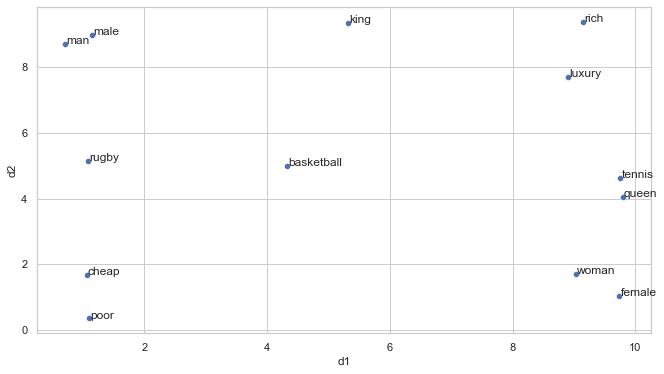

In [174]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11,6)})
sns.set_style('whitegrid')
splot = sns.scatterplot(data=emb_df, x='d1', y='d2')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(emb_df['d1'], emb_df['d2'], emb_df.index.to_series(), plt.gca())

# Set x-axis label
plt.xlabel('d1')
# Set y-axis label
plt.ylabel('d2')

Text(0, 0.5, 'Gender Projection')

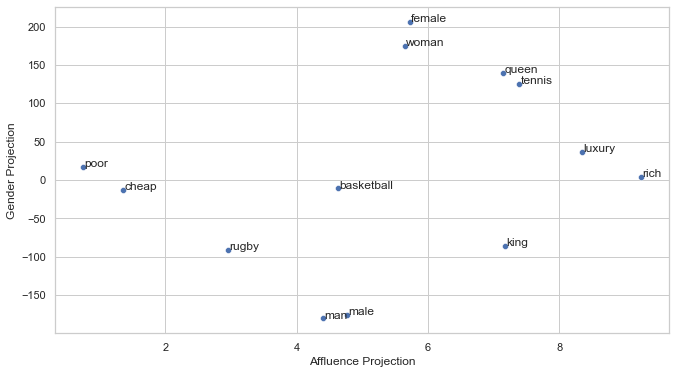

In [175]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11,6)})
sns.set_style('whitegrid')
splot = sns.scatterplot(data=projections_df, x='aff_proj', y='gender_proj')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(projections_df['aff_proj'], projections_df['gender_proj'], projections_df.index.to_series(), plt.gca())

# Set x-axis label
plt.xlabel('Affluence Projection')
# Set y-axis label
plt.ylabel('Gender Projection')

In [176]:
from bokeh.plotting import figure, show

In [177]:

from bokeh.models import LabelSet, ColumnDataSource

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"
p = figure(tools=TOOLS)

p.scatter(projections_df['aff_proj'], projections_df['gender_proj'],
          fill_alpha=0.6,
          line_color=None)
labels = LabelSet(x='off_rating', y='def_rating', text='names',text_font_size='9pt',
                  x_offset=5, y_offset=5, source=ColumnDataSource(projections_df.index), render_mode='canvas')
p.add_layout(labels)
show(p)
show(p)

ValueError: expected a dict or pandas.DataFrame, got Index(['woman', 'poor', 'rich', 'tennis', 'basketball', 'rugby', 'man',
       'queen', 'king', 'cheap', 'luxury', 'female', 'male'],
      dtype='object', name='token')